# Data Preparation

In [1]:
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import pylab

from scipy import ndimage
from skimage import morphology

import pandas as pd
import os

%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [3]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [4]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)

    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image

## Show images

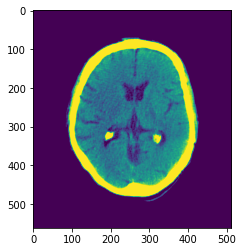

In [36]:
dicomFile = "/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/11417.dcm"

final_image = remove_noise(dicomFile, display=False)

plt.imshow(final_image)

In [37]:
print('Shape: ', final_image.shape)
print('Max pixel value: ', final_image.max())
print('Min pixel value: ', final_image.min())

Shape:  (562, 512)
Max pixel value:  80.0
Min pixel value:  0.0


In [40]:
final_image.shape[0]

562

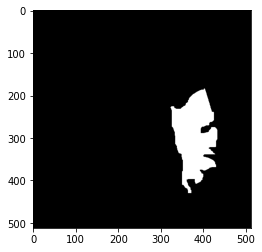

In [7]:
sample_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/10105.png'

# read the mask using skimage
mask = imread(sample_mask)

plt.imshow(mask, cmap='gray')

In [8]:
print('Shape: ', mask.shape)
print('Max pixel value: ', mask.max())
print('Min pixel value: ', mask.min())

Shape:  (512, 512)
Max pixel value:  1
Min pixel value:  0


## Create X-train Y-train X-test Y-test

In [9]:
images_paths = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/")
masks_paths = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/")

In [10]:
images_paths2 = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/")
masks_paths2 = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/KANAMA/MASK/")

In [11]:
len(images_paths), len(masks_paths)

(1130, 1130)

In [12]:
len(images_paths2), len(masks_paths2)

(1091, 1091)

In [13]:
images_paths.sort()
images_paths2.sort()
masks_paths.sort()
masks_paths2.sort()

In [14]:
val_size = int(len(images_paths) * .20)
val_size

226

In [15]:
X_trainFirst = images_paths[val_size:]
X_testFirst = images_paths[:val_size]
Y_trainFirst = masks_paths[val_size:]  # Burada Onemli birsey var!!! Ayni mi acaba maskeler?
Y_testFirst = masks_paths[:val_size]

In [16]:
len(X_trainFirst), len(X_testFirst), len(Y_trainFirst), len(Y_testFirst)

(904, 226, 904, 226)

In [17]:
val_size2 = int(len(images_paths2) * .20)
val_size2

218

In [18]:
X_train = images_paths2[val_size2:]
X_test = images_paths2[:val_size2]
Y_train = masks_paths2[val_size2:]  # Burada Onemli birsey var!!! Ayni mi acaba maskeler?
Y_test = masks_paths2[:val_size2]

In [19]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(873, 218, 873, 218)

In [20]:
MainX_train = X_trainFirst + X_train
MainX_test = X_testFirst + X_test
MainY_train = Y_trainFirst + Y_train
MainY_test = Y_testFirst + Y_test

In [21]:
MainX_train[0], MainY_train[0]

('11377.dcm', '11377.png')

In [22]:
MainX_train[1203], MainY_train[1203]

('13290.dcm', '13290.png')

In [23]:
MainX_train[1768], MainY_train[1768]

('16973.dcm', '16973.png')

In [24]:
MainX_test[0], MainY_test[0]

('10003.dcm', '10003.png')

In [25]:
MainX_test[205], MainY_test[205]

('11282.dcm', '11282.png')

In [26]:
MainX_test[400], MainY_test[400]

('11136.dcm', '11136.png')

**Ohh bee hepsi ayni**

**SIMDI ELIMIZDE LIST VAR AMA BU SADECE STRING OLARAK VAR, BIZ SIMDI BU LISTEYE DIREKT IMAGELARI ALACAGIZ**

## Image Lists olarak X-train'leri olusturma

In [27]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1

In [28]:
# Get lists of images and their masks.
image_id_list = MainX_train
mask_id_list = MainY_train
test_id_list = MainX_test
testMask_id_list = MainY_test


# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((len(test_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [45]:
len(X_train), len(Y_train), len(X_test), len(Y_test)

(1777, 1777, 444, 444)

In [78]:
# X_train

count=0
cnt=0

for i, image_id in enumerate(image_id_list):
    
    
    try:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + image_id
        f = open(path_image)
        flag=1
    except IOError:
        #print("File not accessible")
        flag=2
    finally:
        f.close()
    
    
    if flag == 1:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + image_id
    elif flag == 2:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/' + image_id
    
    #print(image_id)
    
    final_image = remove_noise(path_image, display=False)
    
    if final_image.shape[0] != 512:
        src = final_image
        # set a new height in pixels
        new_height = 512
        # dsize
        dsize = (src.shape[1], new_height)
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #plt.imshow(output)
        print('SHAPE 1 FARKLI')
        cnt+=1

    
    if final_image.shape[1] != 512:
        src = final_image
        # set a new width in pixels
        new_width = 512
        # dsize
        dsize = (new_width, src.shape[0])
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        print('SHAPE 2 FARKLI')
        #plt.imshow(output)
    
    
    # ????????? use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(final_image, axis=-1)
    
    # insert the image into X_train
    X_train[i] = image
    #print(i)
    
    count+=1
    
print(cnt)
X_train.shape

SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 2 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 2 FARKLI
SHAPE 2 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 2 FARKLI
SHAPE 1 FARKLI
SHAPE 2 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
SHAPE 1 FARKLI
42


(1777, 512, 512, 1)

In [45]:
print(cnt)
X_train.shape

42


(1777, 512, 512, 1)

In [47]:
len(X_train), len(Y_train), len(X_test), len(Y_test)

(1777, 1777, 444, 444)

In [48]:
X_train.shape

(1777, 512, 512, 1)

In [79]:
# Y_train

for i, mask_id in enumerate(mask_id_list):
    
    try:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
        f = open(path_mask)
        flag=1
    except IOError:
        #print("File not accessible")
        flag=2
    finally:
        f.close()
    
    
    if flag == 1:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
    elif flag == 2:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/KANAMA/MASK/' + mask_id
    
    #print(mask_id)
    #print(i)
        
    # read the image using skimage
    mask = imread(path_mask)
    
    #print(mask.shape)
    
    if mask.shape[0] != 512:
        #print('ESIT DEGILL')
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #print(mask.shape)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

IndentationError: expected an indented block (<ipython-input-79-870207353a6f>, line 33)

In [50]:
Y_train.shape

(1777, 512, 512, 1)

In [ ]:
# X_test

count=0
cnt=0

for i, image_id in enumerate(test_id_list):
    
    
    try:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + image_id
        f = open(path_image)
        flag=1
    except IOError:
        #print("File not accessible")
        flag=2
    finally:
        f.close()
    
    
    if flag == 1:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + image_id
    elif flag == 2:
        path_image = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/' + image_id
    
    #print(image_id)
    
    final_image = remove_noise(path_image, display=False)
        
    if final_image.shape[0] != 512:
        #print(final_image.shape)
        src = final_image
        # set a new height in pixels
        new_height = 512
        # dsize
        dsize = (src.shape[1], new_height)
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #plt.imshow(output)
        print('SHAPE 1 FARKLI')
        #print(final_image.shape)
        cnt+=1

    if final_image.shape[1] != 512:
        #print(final_image.shape)
        src = final_image
        # set a new width in pixels
        new_width = 512
        # dsize
        dsize = (new_width, src.shape[0])
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        print('***SHAPE 2 FARKLI')
        #print(final_image.shape)
        #plt.imshow(output)
    
    
    # ????????? use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(final_image, axis=-1)
    
    # insert the image into X_train
    X_test[i] = image
    #print(i)
    
    count+=1
    
X_test.shape


In [52]:
print(cnt)

14


In [53]:
X_test.shape

(444, 512, 512, 1)

In [54]:
# Y_test

for i, mask_id in enumerate(testMask_id_list):
    
    try:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
        f = open(path_mask)
        flag=1
    except IOError:
        #print("File not accessible")
        flag=2
    finally:
        f.close()
    
    if flag == 1:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
    elif flag == 2:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/KANAMA/MASK/' + mask_id
    
    #print(mask_id)
    #print(i)
        
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_test[i] = mask

Y_test.shape

(444, 512, 512, 1)

In [55]:
Y_test.shape

(444, 512, 512, 1)

# Model

## Model Architecture

In [56]:
kucukX_train = X_train[:100]
kucukY_train = Y_train[:100]

kucukX_test = X_test[:10]
kucukY_test = Y_test[:10]

In [57]:
kucukY_train.shape

(100, 512, 512, 1)

In [58]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing import image

from sklearn.model_selection import train_test_split

from skimage.transform import resize

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import shutil
import PIL
import pathlib
import pandas as pd
import cv2
from imgaug import augmenters as iaa
import imgaug as ia

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools

import re

In [59]:
def downstream_block(layer, number_filters):
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    cropped_feature_map = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    layer = layers.MaxPool2D(2, strides=2, padding='same')(cropped_feature_map)

    return layer, cropped_feature_map

In [60]:
def upstream_block(layer, number_filters, cropped_feature_map):
    layer = layers.Conv2DTranspose(number_filters, (2, 2), strides=(2, 2), padding='same')(layer)
    layer = layers.concatenate([layer, cropped_feature_map])
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)

    return layer

In [61]:
def u_net():
    input = layers.Input(input_shape)
    layer = input

    cropped_feature_maps = []

    for index in range(steps + 1):
        current_number_filters = number_filters * 2 ** index
        layer, cropped_feature_map = downstream_block(layer, current_number_filters)
        cropped_feature_maps.append(cropped_feature_map)

    layer = cropped_feature_maps.pop()

    for index in range(steps - 1, -1, -1):
        current_number_filters = number_filters * 2 ** index
        layer = upstream_block(layer, current_number_filters, cropped_feature_maps[index])

    output = layers.Conv2D(number_classes, 1, activation='sigmoid')(layer)
    model = Model(input, output)

    return model

In [62]:
input_shape = (512, 512, 1)
img_size = 512
number_filters = 16 
steps = 4
number_classes = 1

In [63]:
model = None
model = u_net()

In [64]:
batch_size = 32

learning_rate = 3e-4
epochs = 2

In [65]:
def polynomial_decay(epoch):
    power = 1.0

    alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
    return alpha

In [66]:
filepath="/Users/esmasert/Desktop/modelss/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, 
                                save_weights_only=True, mode='max', period=1)



lr_decay = LearningRateScheduler(polynomial_decay)

In [67]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [68]:
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['acc'])

In [69]:
train_steps = int(len(X_train) / batch_size)
val_steps = int(len(X_test) / batch_size)

In [70]:
train_steps, val_steps

(55, 13)

In [71]:
# pretrain model decoder
model.fit(X_train, Y_train,
            epochs=epochs,
            steps_per_epoch=train_steps,
            validation_data=(X_test, Y_test),
            validation_steps=val_steps,
            verbose=1)


Epoch 1/2
55/55 [==============================] - 3887s 71s/step - loss: 0.1742 - acc: 0.9745 - val_loss: 0.0672 - val_acc: 0.9825
Epoch 2/2
55/55 [==============================] - 3365s 61s/step - loss: 0.0615 - acc: 0.9838 - val_loss: 0.0629 - val_acc: 0.9825


In [72]:
model.evaluate(kucukX_test, kucukY_test)

1/1 [==============================] - 5s 5s/step - loss: 0.0689 - acc: 0.9770


[0.06894790381193161, 0.9770148992538452]

In [73]:
model.evaluate(X_test, Y_test)

14/14 [==============================] - 147s 10s/step - loss: 0.0629 - acc: 0.9825


[0.06290273368358612, 0.9825368523597717]

In [74]:
# Make a prediction

# use the best epoch
#model.load_weights('/Users/esmasert/Desktop/TrainedCT/model.h5')

test_preds = model.predict(kucukX_test)

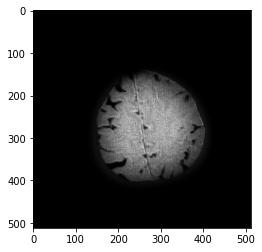

In [77]:
plt.imshow(test_preds[1], cmap='gray')

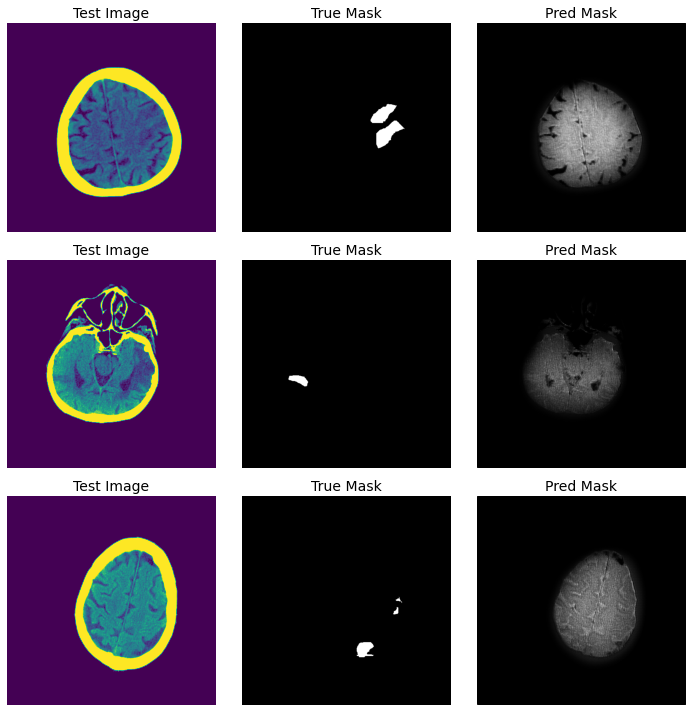

In [76]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = kucukX_test[1]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,2)
mask = kucukY_test[1]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = test_preds[1]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = kucukX_test[2]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask = kucukY_test[2]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = test_preds[2]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = kucukX_test[3]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,8)
mask = mask = kucukY_test[3]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = test_preds[3]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()